# Deletion and Insertion scores for different baselines

In [2]:
import xplique
from xplique.attributions import *
from xplique.metrics import *
import tensorflow as tf
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

from matplotlib import pyplot as plt
# plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

### Create the baselines

In [3]:
def permute_ax1(x):
  x = x.copy()
  x = np.moveaxis(x, 1, 0)
  np.random.shuffle(x)
  x = np.moveaxis(x, 1, 0)
  return x


def random_permute(x):
  x = np.array(x).copy()
  s = x.shape
  x = x.reshape((len(x), -1, 3))
  x = permute_ax1(x)
  return x.reshape(s)

def downsample_upsample(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = tf.image.resize(x, s, method="nearest").numpy()
  return x

def local_permute(x):
  s = (x.shape[-3], x.shape[-2])
  x = tf.image.resize(x, (8, 8), method="bilinear")
  x = random_permute(x)
  x = tf.image.resize(x, s, method="nearest").numpy()
  return x

def scramble_phase(x):
  spectrum = np.fft.fft2(x)
  amplitude = np.abs(spectrum)

  phase = np.angle(spectrum)
  phase = random_permute(phase)
  #phase = np.random.normal(phase.mean(), phase.std(), phase.shape)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x

def scramble_amplitude(x):
  spectrum = np.fft.fft2(x)

  amplitude = np.abs(spectrum)
  amplitude = random_permute(amplitude)

  phase = np.angle(spectrum)

  x = np.abs(np.fft.ifft2(amplitude * np.exp(1j * phase)))

  return x


baselines = {
    'zero': lambda x : tf.zeros(x.shape).numpy(),
    'uniform': lambda x : tf.random.uniform(x.shape, -1, 1).numpy(),
    'normal': lambda x : tf.clip_by_value(tf.random.normal(x.shape), -1, 1).numpy(),
    'permutation': lambda x : random_permute(x),
    'local_mean': lambda x : downsample_upsample(x),
    'local_permutation': lambda x : local_permute(x),
    'mean': lambda x : np.ones(x.shape) * np.mean(x, (1, 2))[:, None, None, :],
    'median': lambda x : np.ones(x.shape) * np.median(x, (1, 2))[:, None, None, :],
    'random_color': lambda x : np.ones(x.shape) * (np.random.rand(3) * 2 - 1.),
    'scramble_phase': lambda x : scramble_phase(x),
    'scramble_amplitude': lambda x : scramble_amplitude(x)
}

### Set up the model and the data

In [4]:
model = tf.keras.applications.ResNet50V2(classifier_activation='linear')

def preprocess(images):
  return tf.keras.applications.resnet_v2.preprocess_input(np.array(images, dtype=np.float32))

2024-07-01 15:09:44.951305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-01 15:09:44.951563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-01 15:09:45.006368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-01 15:09:45.006595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-01 15:09:45.006813: I tensorflow/compiler/xla/stream_executo

In [5]:
X = np.load('../imagenet_samples.npy')
X = preprocess(X)
Y = tf.one_hot(np.argmax(model.predict(X, 256), -1), 1_000)
X.shape, Y.shape

2024-07-01 15:09:56.913257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801


1/1 [==============================] - 2s 2s/step


2024-07-01 15:09:58.219617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


((200, 224, 224, 3), TensorShape([200, 1000]))

In [6]:
X.shape, Y.shape

((200, 224, 224, 3), TensorShape([200, 1000]))

### Generate the explanations

In [7]:
from xplique.attributions import *

grad_samples = 128

def get_explainers(model, batch_size):
    return [
        Saliency(model, batch_size=batch_size),
        GradientInput(model, batch_size=batch_size),
        SmoothGrad(model, batch_size=batch_size, nb_samples=grad_samples, noise=0.15),
        GradCAM(model, batch_size=batch_size),
        GradCAMPP(model, batch_size=batch_size),
        VarGrad(model, batch_size=batch_size, nb_samples=grad_samples),
        SquareGrad(model, batch_size=batch_size, nb_samples=grad_samples),
        IntegratedGradients(model, batch_size=batch_size, steps=grad_samples),
        Occlusion(model,batch_size=batch_size, patch_stride=7, patch_size=7),
        GuidedBackprop(model, batch_size=batch_size),
        DeconvNet(model, batch_size=batch_size),
        Rise(model, batch_size=batch_size, grid_size=8, nb_samples=3000),
        SobolAttributionMethod(model, batch_size=batch_size, grid_size=8, nb_design=32),
        HsicAttributionMethod(model, batch_size=batch_size, grid_size=8, nb_design=1000),
    ]

In [8]:
limit = 1_000
explainers = get_explainers(model, batch_size=256)

for exp in explainers:
  exp_name = exp.__class__.__name__
  phis = exp(X[:limit], Y[:limit])

  file_name = f"resnet50_{exp_name}.npy"
  np.save(file_name, phis)

  print('done for', exp_name)

done for Saliency
done for GradientInput


2024-07-01 15:10:20.932422: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 15:10:20.932456: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


done for SmoothGrad
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
done for GradCAM
done for GradCAMPP
done for VarGrad
done for SquareGrad
done for IntegratedGradients
done for Occlusion
done for GuidedBackprop
done for DeconvNet
done for Rise
done for SobolAttributionMethod
done for HsicAttributionMethod


### Compute the Deletion and Insertion curves

In [16]:
import os

l = 300
bs = 128
steps = 10

RESULTS = []
for exp in explainers:
  exp_name = exp.__class__.__name__
  for baseline_text, baseline_func in baselines.items():
    
    deletion = Deletion(model, X[:l], Y[:l], batch_size=bs, steps=steps, baseline_mode = baseline_func)
    insertion = Insertion(model, X[:l], Y[:l], batch_size=bs, steps=steps, baseline_mode = baseline_func)

    p = f"resnet50_{exp_name}.npy"
    h = np.load(p)[:l]
        
    if len(h.shape) == 4:
      h = np.mean(h, -1)
        
    h = np.abs(h)
        
    s_del = deletion.detailed_evaluate(np.array(h))
    s_ins = insertion.detailed_evaluate(np.array(h))
        
    RESULTS.append((p[:-4] + f"_{baseline_text}", s_del, s_ins))
    print('done for', p[:-4] + f"_{baseline_text}")

done for resnet50_Saliency_zero
done for resnet50_Saliency_uniform
done for resnet50_Saliency_normal
done for resnet50_Saliency_permutation
done for resnet50_Saliency_local_mean
done for resnet50_Saliency_local_permutation
done for resnet50_Saliency_mean
done for resnet50_Saliency_median
done for resnet50_Saliency_random_color
done for resnet50_Saliency_scramble_phase
done for resnet50_Saliency_scramble_amplitude
done for resnet50_GradientInput_zero
done for resnet50_GradientInput_uniform
done for resnet50_GradientInput_normal
done for resnet50_GradientInput_permutation
done for resnet50_GradientInput_local_mean
done for resnet50_GradientInput_local_permutation
done for resnet50_GradientInput_mean
done for resnet50_GradientInput_median
done for resnet50_GradientInput_random_color
done for resnet50_GradientInput_scramble_phase
done for resnet50_GradientInput_scramble_amplitude
done for resnet50_SmoothGrad_zero
done for resnet50_SmoothGrad_uniform
done for resnet50_SmoothGrad_normal
done

### Take a look at what's in each metric

0.45454545454545453


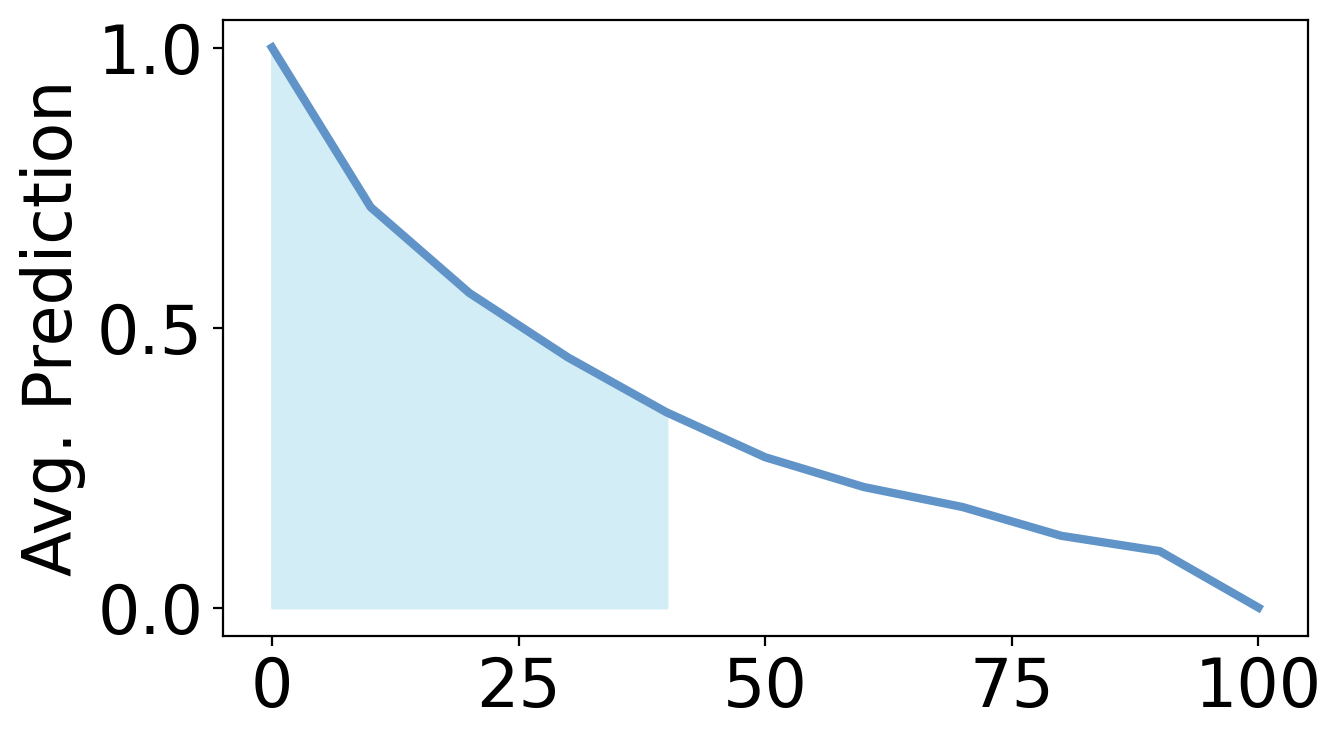

0.8181818181818182


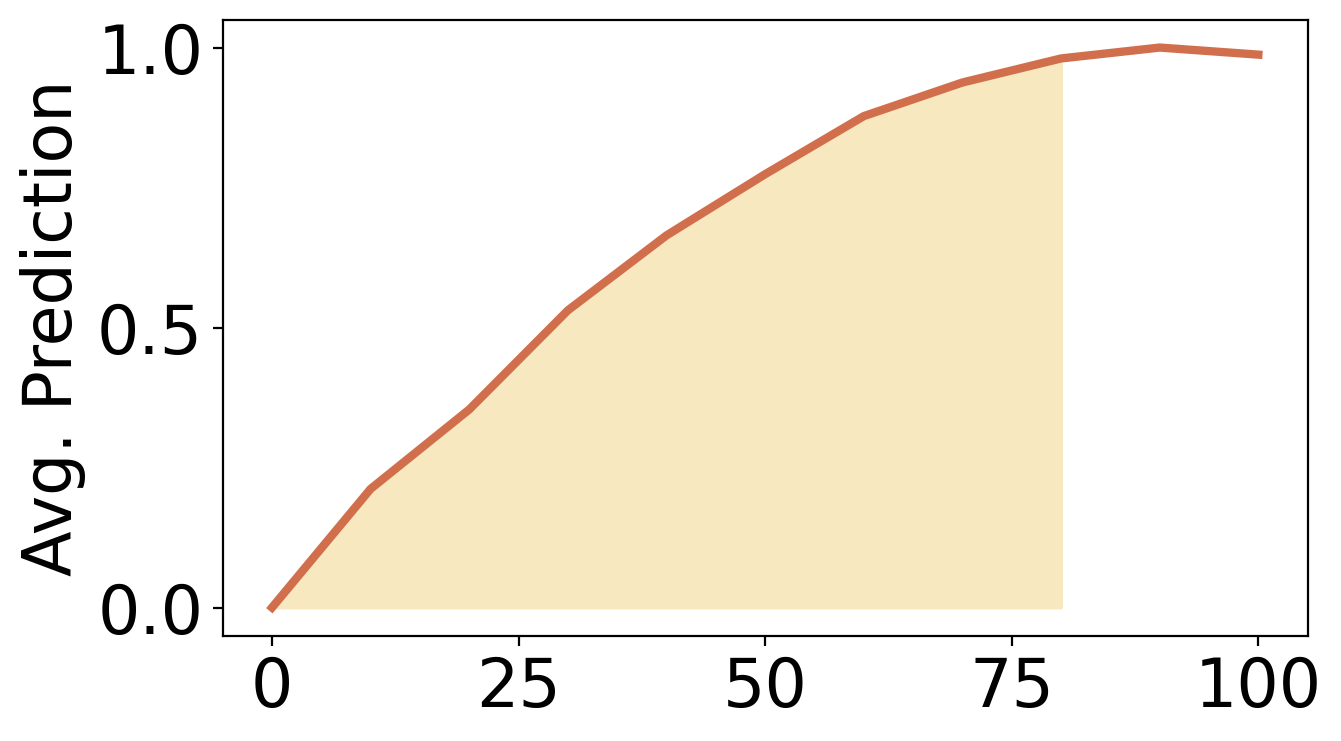

0.2727272727272727


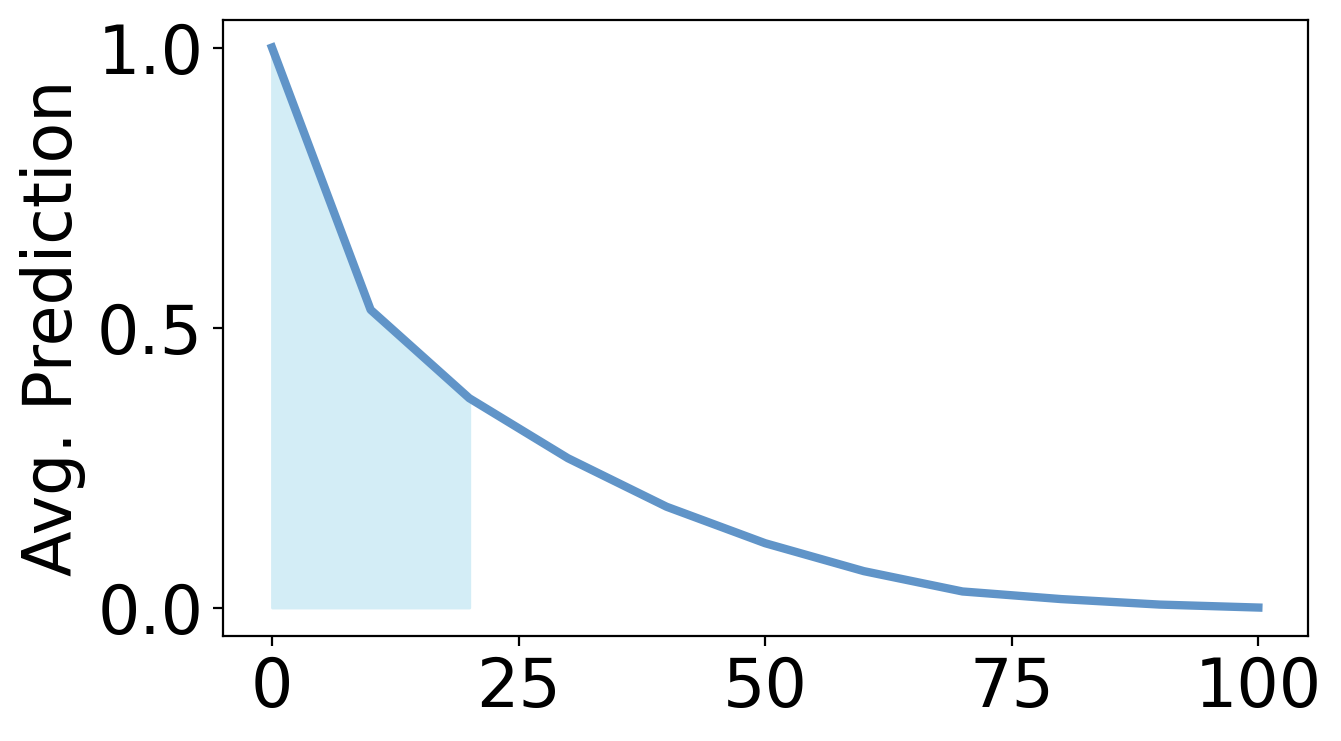

0.8181818181818182


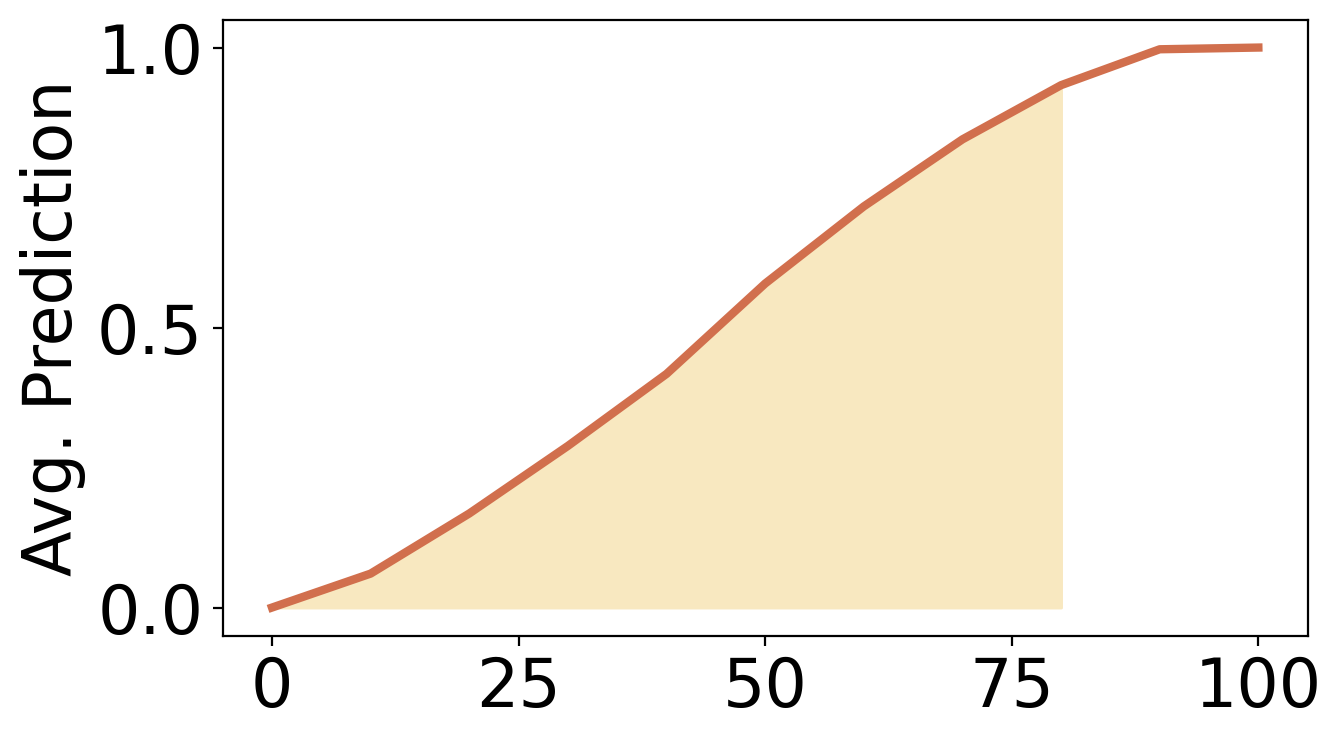

In [29]:
import scipy
import matplotlib as mpl
from scipy import interpolate
import matplotlib

def set_size(w,h):
  plt.rcParams["figure.figsize"] = [w,h]

def fontsize(mult):
  matplotlib.rcParams.update({'font.size': 12 * mult})

mpl.rcdefaults()
fontsize(2.0)
set_size(7, 4)
# plt.style.use("seaborn-ticks")

blue_1 = (96, 148, 200)
blue_2 = (211, 237, 246)
orange_1 = (209, 111, 77)
orange_2 = (248, 232, 192)

def c(color):
  return np.array(color) / 255.0

lw = 3.0

def norm(y):
  y = np.array(y)
  y -= np.min(y)
  y /= np.max(y)
  return y

def auc(y, c, mode='ins', p=0.8):
  total = np.sum(y)
  x_p = None
  for i in range(len(y)):
    s = np.sum(y[:i+1])
    if s >= 0.8 * total and x_p is None:
      x_p = i
  plt.fill_between(np.arange(x_p), y[:x_p]*0.0, y[:x_p], color=c)
  print(float(x_p) / len(y))

for i in range(2):
  p, sdel, sins = RESULTS[i]

  d = [sdel[k] for k in sdel.keys()]
  d = norm(d)
  plt.plot(d, color=c(blue_1), lw=lw)
  auc(d, c(blue_2), 'del')
  plt.xticks(np.linspace(0, len(d)-1, 11//2), np.linspace(0, 100, 11//2).astype(np.int32))
  plt.ylabel('Avg. Prediction')
  plt.show()

  d = [sins[k] for k in sins.keys()]
  d = norm(d)
  plt.plot(d, color=c(orange_1), lw=lw)
  auc(d, c(orange_2), 'ins')
  plt.xticks(np.linspace(0, len(d)-1, 11//2), np.linspace(0, 100, 11//2).astype(np.int32))
  plt.ylabel('Avg. Prediction')
  plt.show()

### Get a summarized version of the metrics using AUC

In [43]:
def compute_metric_from_curve(curve: Dict):
    scores = np.array(list(curve.values()))
    auc = np.mean(scores[:-1] + scores[1:]) * 0.5  # trapezoidal rule
    return auc

In [44]:
results_summarized = []
for exp_name, deletion, insertion in RESULTS:
    d = compute_metric_from_curve(deletion)
    i = compute_metric_from_curve(insertion)
    results_summarized.append((exp_name, d, i))

In [45]:
results_summarized

[('resnet50_Saliency_zero', 6.019281387329102, 12.03580379486084),
 ('resnet50_Saliency_uniform', 3.6750903129577637, 9.600398063659668),
 ('resnet50_Saliency_normal', 3.234316349029541, 8.85632610321045),
 ('resnet50_Saliency_permutation', 4.804511547088623, 10.47819709777832),
 ('resnet50_Saliency_local_mean', 4.886733055114746, 11.1471529006958),
 ('resnet50_Saliency_local_permutation', 3.610703945159912, 9.264681816101074),
 ('resnet50_Saliency_mean', 6.2013444900512695, 12.244645118713379),
 ('resnet50_Saliency_median', 6.003127098083496, 11.880390167236328),
 ('resnet50_Saliency_random_color', 4.078551292419434, 8.165367126464844),
 ('resnet50_Saliency_scramble_phase', 3.753021717071533, 9.1506986618042),
 ('resnet50_Saliency_scramble_amplitude',
  3.228311061859131,
  8.687785148620605),
 ('resnet50_GradientInput_zero', 6.115113258361816, 11.627424240112305),
 ('resnet50_GradientInput_uniform', 3.63116717338562, 8.43792724609375),
 ('resnet50_GradientInput_normal', 3.24085187911

### Plot the results

In [25]:
import pandas as pd
from typing import List, Dict, Tuple

In [74]:
def set_size_custom(width, height):
    """ Helper function to set the size of the plot """
    plt.gcf().set_size_inches(width, height)

def plot_method_rankings_custom(data: Dict[Tuple[str, str], Tuple[float, float]]):
    """
    Generates line plots to visualize the rankings of methods based on their positions for two
    separate metrics (similar to 'deletion' and 'insertion' ranks), styled similarly to the given code.

    Args:
    data (Dict[Tuple[str, str], Tuple[float, float]]): Dictionary with keys as tuples of (name, method name)
                                                       and values as tuples of (first value, second value).
    """
    # Convert dictionary to DataFrame for easier manipulation
    df = pd.DataFrame({
        'Name': [k[0] for k in data.keys()],
        'Method': [k[1] for k in data.keys()],
        'Value 1': [v[0] for v in data.values()],
        'Value 2': [v[1] for v in data.values()]
    })

    # Prepare ranks based on values
    df['Rank Value 1'] = df.groupby('Name')['Value 1'].rank(method='min', ascending=True)
    df['Rank Value 2'] = df.groupby('Name')['Value 2'].rank(method='min', ascending=False)

    methods = sorted(set(df['Method']))
    baselines = sorted(set(df['Name']))

    sns.set(font_scale=1.4)
    set_size_custom(13, 10)
    cmap = plt.get_cmap('viridis_r')

    # Plotting for Value 1 (like 'deletion')
    lw = 3.0
    plt.figure(figsize=(13, 10))
    for m in methods:
        order = [len(methods) - df[(df['Name'] == b) & (df['Method'] == m)]['Rank Value 1'].values[0] for b in baselines]
        color = cmap((len(methods) - np.mean(order)) / len(methods))
        plt.plot(order, label=m, c=color, linewidth=lw)

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45), fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True, facecolor='white')
    plt.xticks(range(len(baselines)), baselines, rotation=45)
    # plt.yticks(range(1, len(methods) + 1))
    plt.yticks([0, len(methods)], [len(methods), 1])
    plt.ylabel('Rank')
    plt.title("Deletion Ranking")
    plt.tight_layout()
    plt.show()

    # Plotting for Value 2 (like 'insertion')
    plt.figure(figsize=(13, 10))
    for m in methods:
        order = [len(methods) - df[(df['Name'] == b) & (df['Method'] == m)]['Rank Value 2'].values[0] for b in baselines]
        color = cmap((len(methods) - np.mean(order)) / len(methods))
        plt.plot(order, label=m, c=color, linewidth=lw)

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.45), fancybox=True, shadow=True, borderpad=0.5, ncol=4, frameon=True, facecolor='white')
    plt.xticks(range(len(baselines)), baselines, rotation=45)
    # plt.yticks(range(1, len(methods) + 1))
    plt.yticks([0, len(methods)], [len(methods), 1])
    plt.ylabel('Rank')
    plt.title("Insertion ranking")
    plt.tight_layout()
    plt.show()

In [70]:
# Get the results in an appropriate format for the plotting function
def format_results_to_dict(result_list: List[Tuple[str, float, float]]) -> Dict[Tuple[str, str], Tuple[float, float]]:
    result_dict = {}
    for exp_name, deletion, insertion in result_list:
        if len(exp_name.split('_')) == 4:
            baseline_name = exp_name.split('_')[2] + exp_name.split('_')[3]
        else:
            baseline_name = exp_name.split('_')[2]
        method_name = exp_name.split('_')[1]
        key = (baseline_name, method_name)
        result_dict[key] = (deletion, insertion)
    return result_dict

In [71]:
results_dictionary = format_results_to_dict(results_summarized)

In [72]:
results_dictionary

{('zero', 'Saliency'): (6.019281387329102, 12.03580379486084),
 ('uniform', 'Saliency'): (3.6750903129577637, 9.600398063659668),
 ('normal', 'Saliency'): (3.234316349029541, 8.85632610321045),
 ('permutation', 'Saliency'): (4.804511547088623, 10.47819709777832),
 ('localmean', 'Saliency'): (4.886733055114746, 11.1471529006958),
 ('localpermutation', 'Saliency'): (3.610703945159912, 9.264681816101074),
 ('mean', 'Saliency'): (6.2013444900512695, 12.244645118713379),
 ('median', 'Saliency'): (6.003127098083496, 11.880390167236328),
 ('randomcolor', 'Saliency'): (4.078551292419434, 8.165367126464844),
 ('scramblephase', 'Saliency'): (3.753021717071533, 9.1506986618042),
 ('scrambleamplitude', 'Saliency'): (3.228311061859131, 8.687785148620605),
 ('zero', 'GradientInput'): (6.115113258361816, 11.627424240112305),
 ('uniform', 'GradientInput'): (3.63116717338562, 8.43792724609375),
 ('normal', 'GradientInput'): (3.240851879119873, 7.434430122375488),
 ('permutation', 'GradientInput'): (4.9

<Figure size 1300x1000 with 0 Axes>

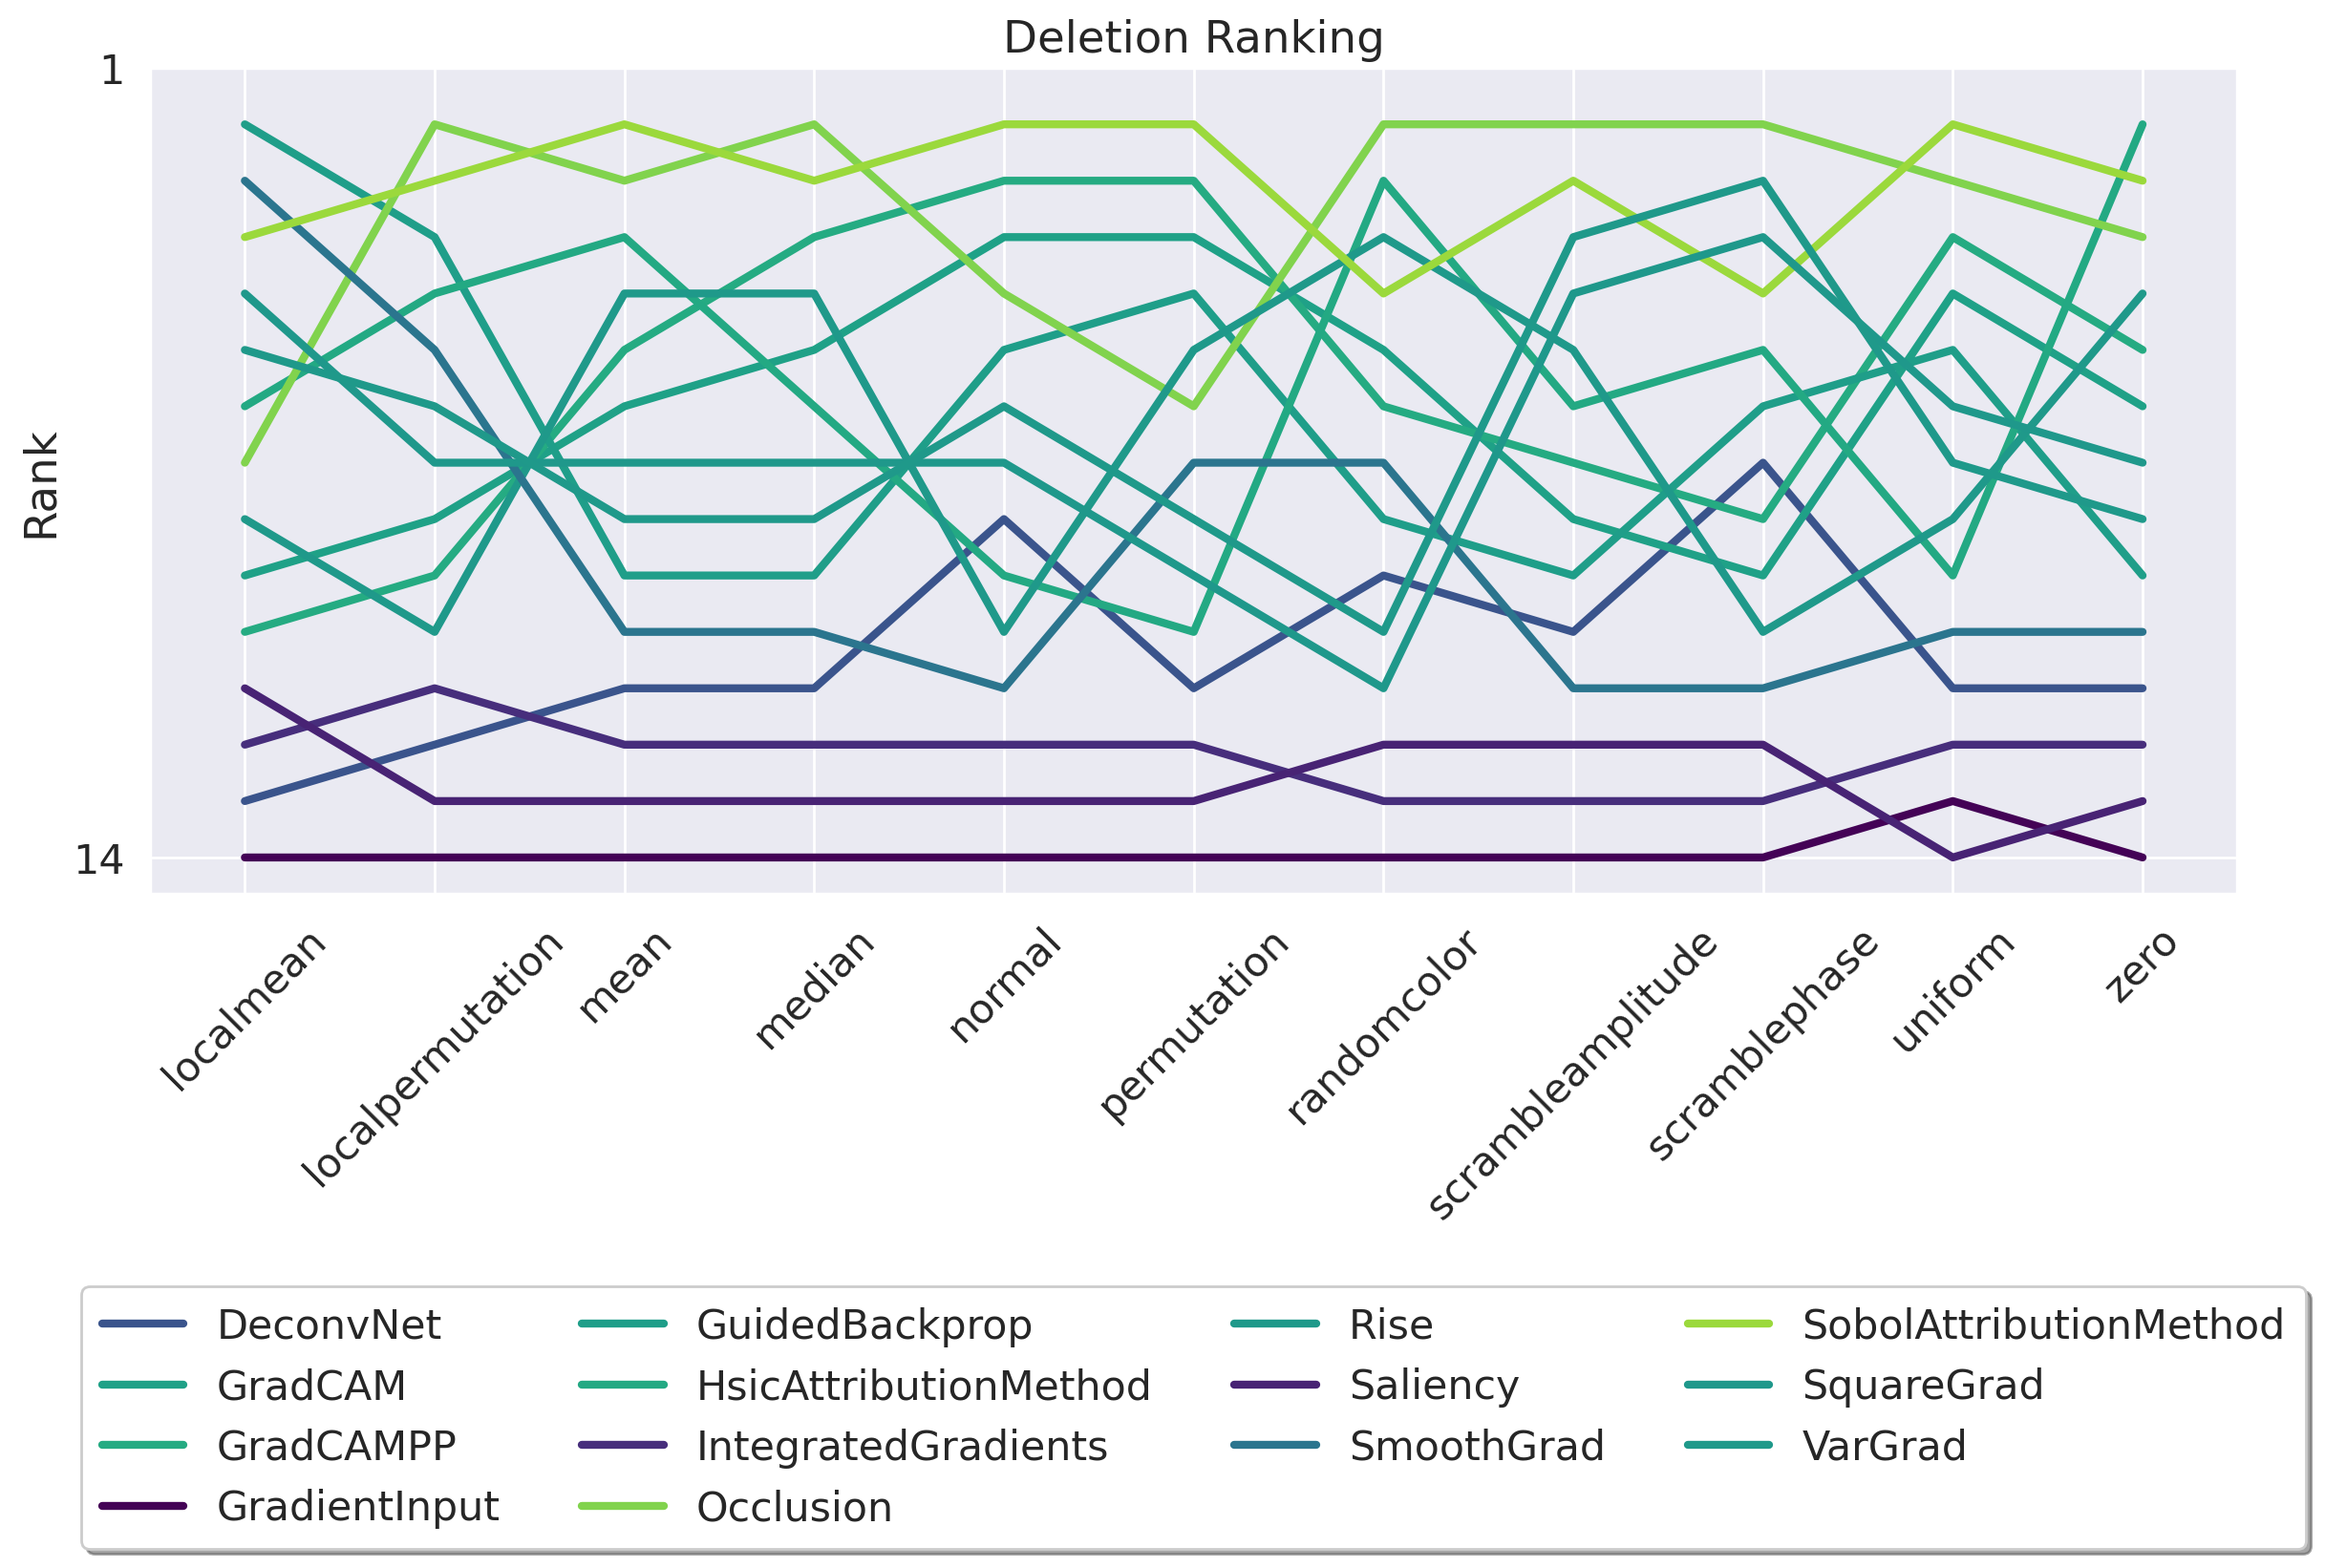

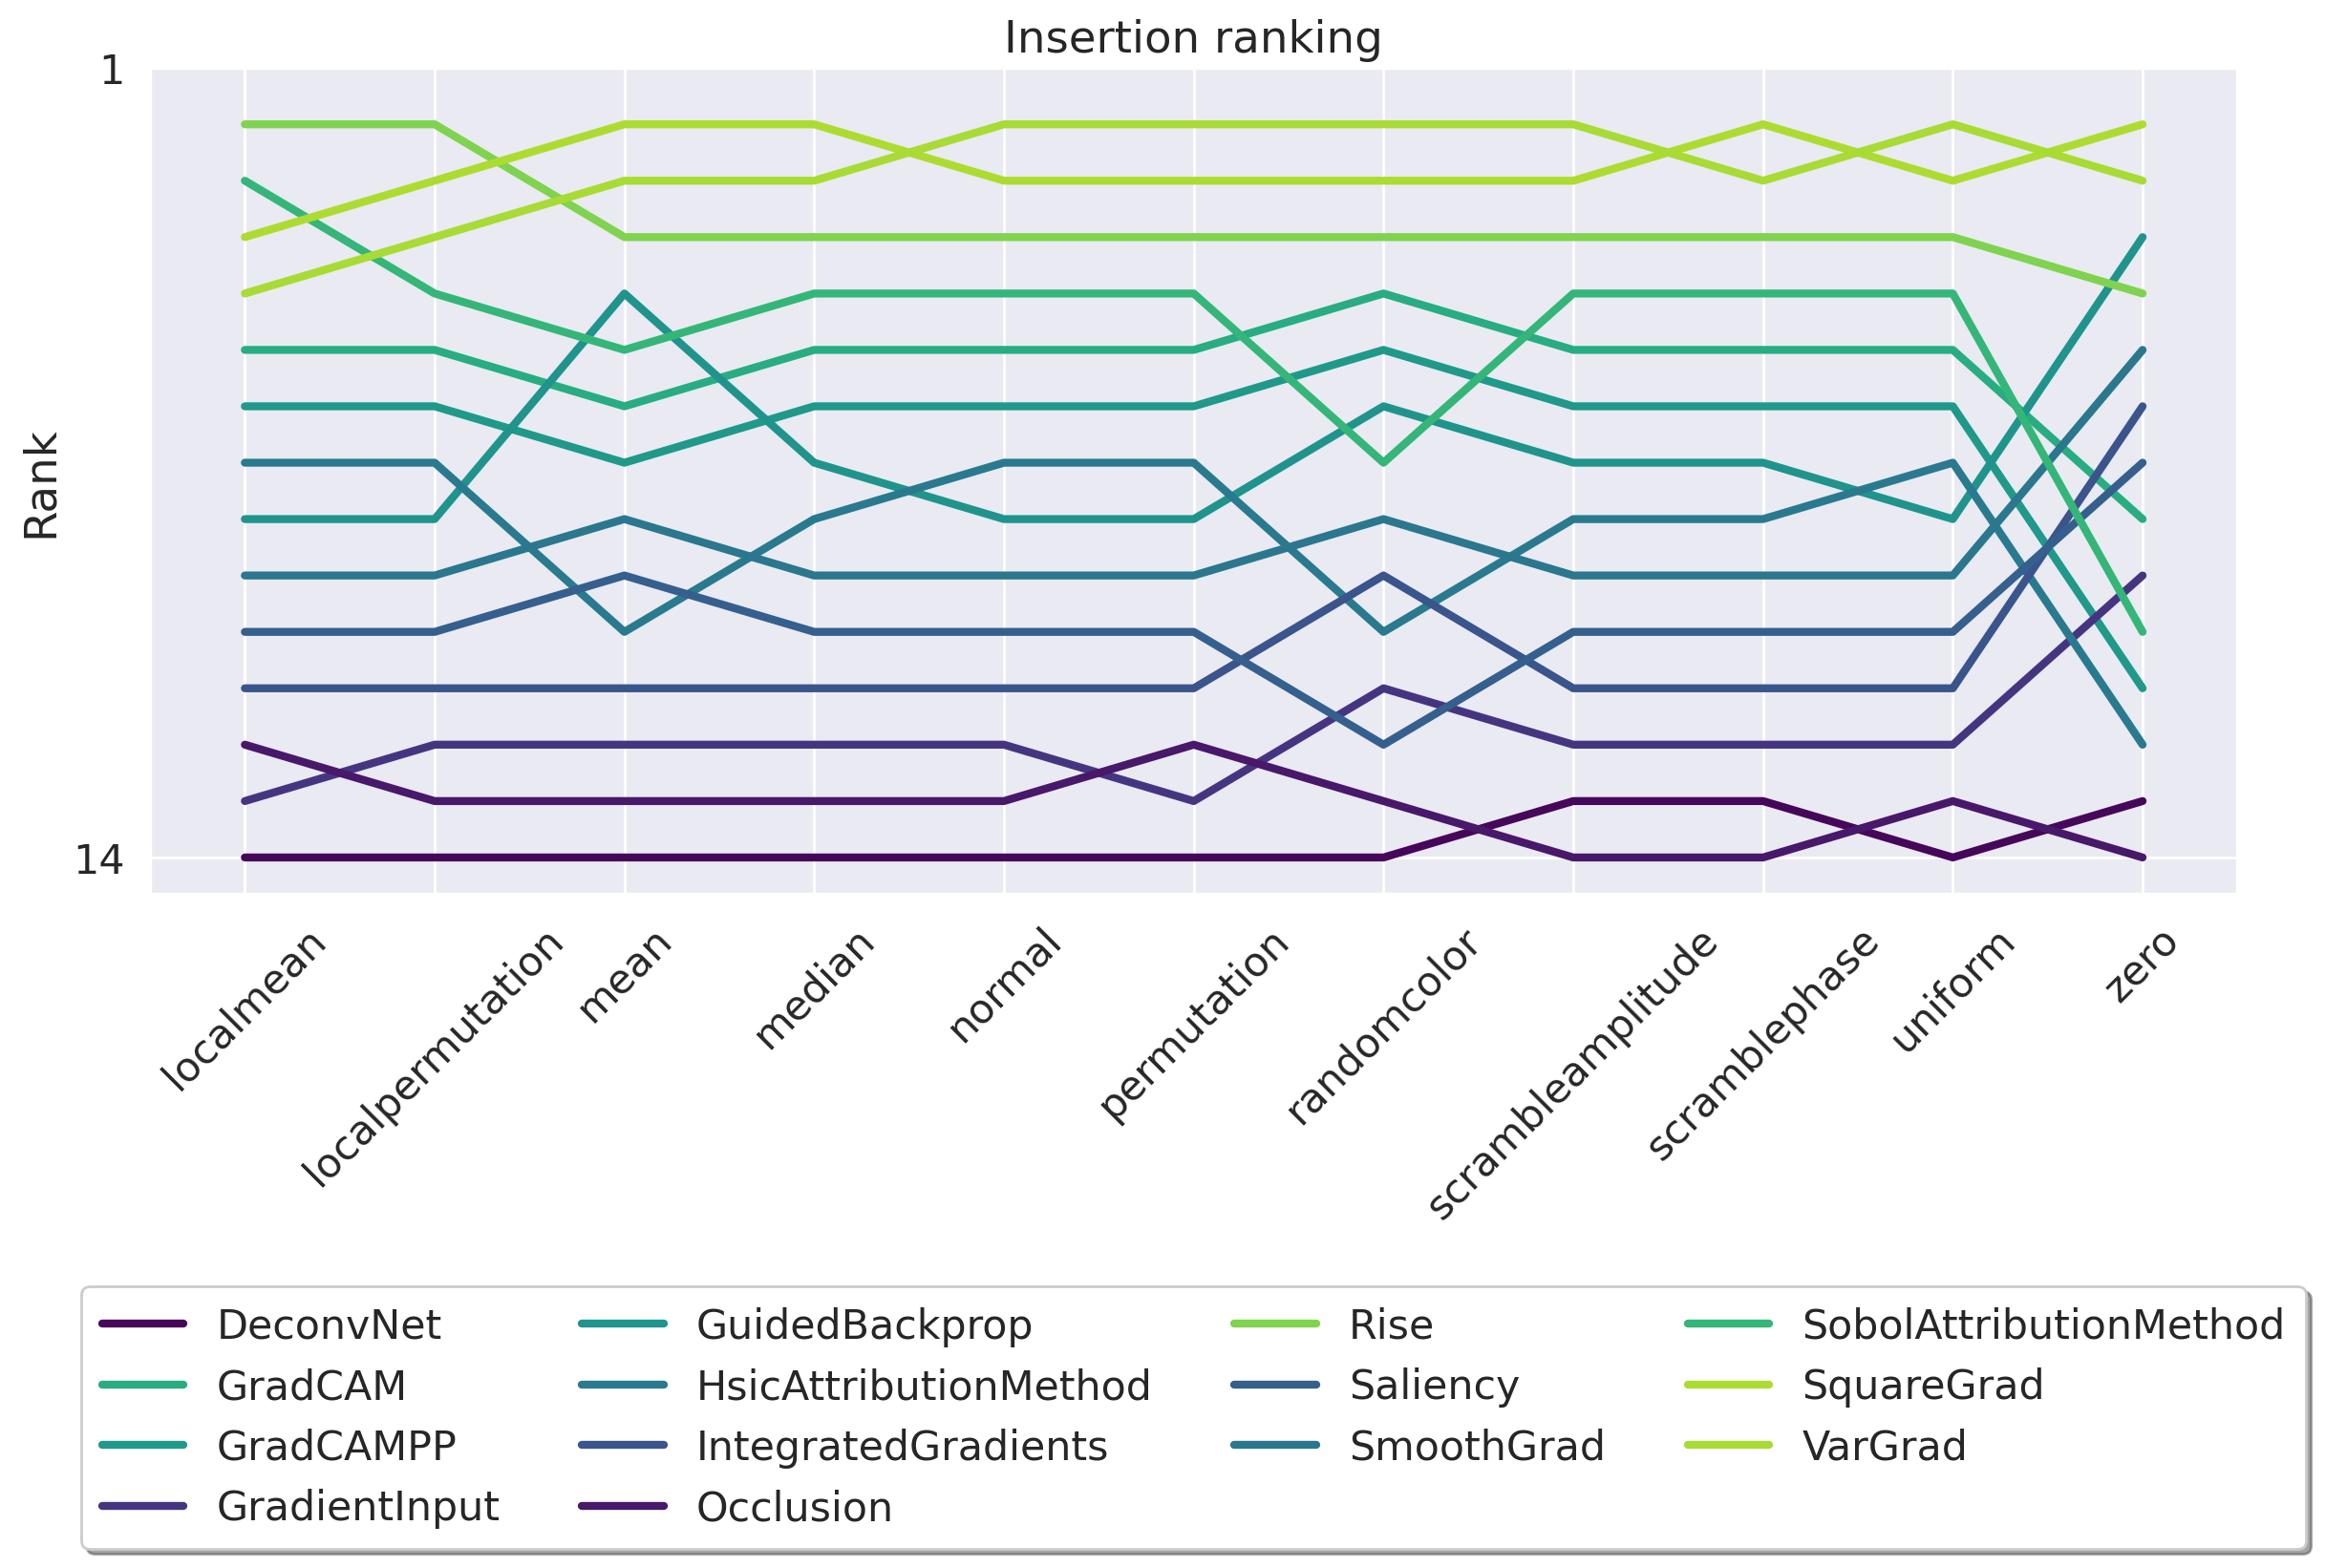

In [75]:
plot_method_rankings_custom(results_dictionary)

The results are slightly different because less samples are taken in this notebook compared to the paper, but the problem is still apparent

In [76]:
# Save the results in pickle format
import pickle
with open('results_resnet50.pickle', 'wb') as handle:
    pickle.dump(results_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)